In [1]:
# importing liberaries
import yfinance as yf
import pandas as pd

In [2]:
bhavcopy_path = '/Users/somrajbharadwaj/nse bhavcopy (1).csv'

df_bhav = pd.read_csv(bhavcopy_path)
df_bhav.head()

,SYMBOL,NAME OF COMPANY,SERIES,DATE OF LISTING,PAID UP VALUE,MARKET LOT,ISIN NUMBER,FACE VALUE
0,20MICRONS,20 Microns Limited,EQ,06-OCT-2008,5,1,INE144J01027,5
1,21STCENMGM,21st Century Management Services Limited,BE,03-MAY-1995,10,1,INE253B01015,10
2,360ONE,360 ONE WAM LIMITED,EQ,19-SEP-2019,1,1,INE466L01038,1
3,3IINFOLTD,3i Infotech Limited,EQ,22-OCT-2021,10,1,INE748C01038,10
4,3MINDIA,3M India Limited,EQ,13-AUG-2004,10,1,INE470A01017,10


In [3]:
df_bhav.columns = df_bhav.columns.str.strip()

df_eq = df_bhav[df_bhav['SERIES'] == 'EQ']

symbols = df_eq['SYMBOL'].unique().tolist()
symbols = [symbol + ".NS" for symbol in symbols]

print("Total EQ stocks found:", len(symbols))
print("Example tickers:", symbols[:5])

Total EQ stocks found: 1797
Example tickers: ['20MICRONS.NS', '360ONE.NS', '3IINFOLTD.NS', '3MINDIA.NS', '5PAISA.NS']


In [4]:
import os
import time
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
import yfinance as yf

# Silence yfinance noise
logging.getLogger("yfinance").setLevel(logging.CRITICAL)

# Output folder in Drive
output_dir = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset"
os.makedirs(output_dir, exist_ok=True)

START_DATE = "2006-01-01"
END_DATE = "2025-10-31"

def download_stock(symbol: str) -> str:
    try:
        filename = f"{symbol.replace('.NS', '')}_2006_2025.csv"
        filepath = os.path.join(output_dir, filename)

        if os.path.exists(filepath):
            return f"Already exists: {symbol}"

        # Single-ticker download
        data = yf.download(
            symbol,
            start=START_DATE,
            end=END_DATE,
            progress=False,
            auto_adjust=False,
            threads=False,
            interval="1d"
        )

        if data is None or data.empty:
            return f"No data: {symbol}"

        data.reset_index(inplace=True)
        data.to_csv(filepath, index=False)
        return f"Downloaded: {symbol} ({len(data)} rows)"

    except Exception as e:
        return f"Failed {symbol}: {e}"

# Try with fewer threads first
max_threads = 20  # start low, you can increase to 5 later

print("Starting multithreaded download...")

success = no_data = failed = 0

with ThreadPoolExecutor(max_workers=max_threads) as executor:
    futures = {executor.submit(download_stock, symbol): symbol for symbol in symbols}

    from tqdm.auto import tqdm
    for future in tqdm(as_completed(futures), total=len(futures), desc="Downloading"):
        result = future.result()
        print(result)

        if result.startswith("Downloaded"):
            success += 1
        elif result.startswith("No data"):
            no_data += 1
        elif result.startswith("Failed"):
            failed += 1



print("\nSummary:")
print("Downloaded:", success)
print("No data:", no_data)
print("Failed:", failed)
print("Total tried:", len(symbols))


Starting multithreaded download...


Downloading:   0%|          | 0/1797 [00:00<?, ?it/s]

Already exists: MANGLMCEM.NS
Already exists: INDIAMART.NS
Already exists: ABMINTLLTD.NS
Already exists: DPWIRES.NS
Already exists: AVALON.NS
Already exists: SANGINITA.NS
Already exists: GANDHAR.NS
Already exists: GALLANTT.NS
Already exists: INDIAGLYCO.NS
Already exists: DPSCLTD.NS
Already exists: AVADHSUGAR.NS
Already exists: ABINFRA.NS
Already exists: SANGHVIMOV.NS
Already exists: ABREL.NS
Already exists: ABFRL.NS
Already exists: MANGALAM.NS
Already exists: INDIACEM.NS
Already exists: GANDHITUBE.NS
Already exists: DPABHUSHAN.NS
Already exists: AUTOIND.NS
Already exists: SANGHIIND.NS
Already exists: ABDL.NS
Already exists: MANCREDIT.NS
Already exists: INDHOTEL.NS
Already exists: DONEAR.NS
Already exists: AUTOAXLES.NS
Already exists: GANECOS.NS
Already exists: SANGAMIND.NS
Already exists: ABCAPITAL.NS
Already exists: MANBA.NS
Already exists: INDGN.NS
Already exists: DOMS.NS
Already exists: AUSOMENT.NS
Already exists: SANDUMA.NS
Already exists: GANESHBE.NS
Already exists: ABBOTINDIA.NS
A

In [5]:
import os
import pandas as pd

#  Settings 
data_dir = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset"
output_path = os.path.join(data_dir, "top_250_by_value.csv")

# Make sure these bluechip names are in the final list if possible
must_include = [
    "RELIANCE", "TCS", "INFY", "ICICIBANK","BHEL", "TATAMOTORS", "LT", "SBIN", "BAJFINANCE"
]

value_records = []

# === Step 1: Scan all CSV files and compute total traded value per symbol ===
for fname in os.listdir(data_dir):
    # Skip the aggregated output file and anything that isn't a CSV
    if not fname.endswith(".csv") or "top_250" in fname:
        continue

    file_path = os.path.join(data_dir, fname)

    try:
        frame = pd.read_csv(file_path)

        # Some NSE files have a duplicated header row at index 0
        if not frame.empty:
            frame = frame.iloc[1:].reset_index(drop=True)

        # Convert to numeric (invalid values -> NaN)
        frame["Volume"] = pd.to_numeric(frame["Volume"], errors="coerce")
        frame["Close"] = pd.to_numeric(frame["Close"], errors="coerce")

        # Total traded value for entire file
        traded_value = (frame["Volume"] * frame["Close"]).sum(skipna=True)

        # Extract symbol from filename 
        symbol_name = fname.split("_")[0]
        value_records.append((symbol_name, traded_value))

    except Exception as exc:
        print(f"Skipping {fname}: {exc}")

# Build table, aggregate per symbol, sort by traded value 
value_df = pd.DataFrame(value_records, columns=["Symbol", "TotalTradedValue"])

# If the same symbol appears in multiple files, combine them
value_df = (
    value_df
    .groupby("Symbol", as_index=False)["TotalTradedValue"]
    .sum()
    .sort_values(by="TotalTradedValue", ascending=False)
    .reset_index(drop=True)
)

# Build final list of 250 symbols (value-based + must-include) 
available_symbols = set(value_df["Symbol"])

# Warn about must_include symbols that aren't present
missing_must = [s for s in must_include if s not in available_symbols]
if missing_must:
    print(
        "WARNING - these must_include symbols are missing from value_df and "
        "cannot be included:",
        missing_must
    )

# Keep only those must_include that actually exist
must_include_present = [s for s in must_include if s in available_symbols]

# First: straight top 250 by traded value
core_top_250 = value_df["Symbol"].head(250).tolist()

# Merge required bluechips + core list, remove duplicates while preserving order
ordered_candidates = must_include_present + core_top_250
seen = set()
final_symbol_list = []

for sym in ordered_candidates:
    if sym not in seen:
        seen.add(sym)
        final_symbol_list.append(sym)

# Ensure we have exactly 250 symbols (or fewer if not enough exist)
final_symbol_list = final_symbol_list[:250]

#  Filter to final symbols, keep that order, and save 
filtered_df = value_df[value_df["Symbol"].isin(final_symbol_list)].copy()

# Enforce the desired order using a Categorical
filtered_df["Symbol"] = pd.Categorical(
    filtered_df["Symbol"],
    categories=final_symbol_list,
    ordered=True,
)
filtered_df = filtered_df.sort_values("Symbol").reset_index(drop=True)

filtered_df.to_csv(output_path, index=False)

print(f"Top 250 stock list successfully saved at: {output_path}")
print("Sample symbols (first 10):", list(filtered_df["Symbol"][:10]))



Top 250 stock list successfully saved at: /Users/somrajbharadwaj/project/final_data_science/venv/dataset/top_250_by_value.csv
Sample symbols (first 10): ['RELIANCE', 'TCS', 'INFY', 'ICICIBANK', 'BHEL', 'TATAMOTORS', 'LT', 'SBIN', 'BAJFINANCE', 'top250']


In [6]:
import os
import pandas as pd

# SETTINGS

base_folder = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset"
symbols_file = os.path.join(base_folder, "top_250_by_value.csv")
out_file = os.path.join(base_folder, "merged_top250_clean.csv")

# LOAD SYMBOL LIST

symbols_df = pd.read_csv(symbols_file)
symbols = symbols_df["Symbol"].dropna().astype(str).tolist()

all_frames = []

# READ + CLEAN EACH STOCK FILE

for sym in symbols:
    csv_name = f"{sym}_2006_2025.csv"
    csv_path = os.path.join(base_folder, csv_name)

    if not os.path.isfile(csv_path):
        print(f"[Missing] {sym}: {csv_name}")
        continue

    try:
        temp = pd.read_csv(csv_path)

        # Some downloaded files may contain an extra first row; remove it safely
        if len(temp) > 0 and str(temp.iloc[0].get("Date", "")).lower() in ["date", "nan", "none", ""]:
            temp = temp.iloc[1:].copy()

        temp.reset_index(drop=True, inplace=True)

        # Parse and clean datatypes
        temp["Date"] = pd.to_datetime(temp["Date"], errors="coerce")

        numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
        for c in numeric_cols:
            if c in temp.columns:
                temp[c] = pd.to_numeric(temp[c], errors="coerce")

        # Keep valid trading rows only
        temp = temp.dropna(subset=["Date", "Close"]).copy()

        # Tag stock code
        temp["Stock"] = sym

        all_frames.append(temp)

    except Exception as err:
        print(f"[Skipped] {sym}: {err}")

# MERGE + SAVE

if all_frames:
    merged_df = pd.concat(all_frames, ignore_index=True)
    merged_df.to_csv(out_file, index=False)

    print(f"✅ Clean merged dataset saved: {out_file}")
    print(f"Rows: {merged_df.shape[0]} | Columns: {merged_df.shape[1]}")
else:
    print("⚠️ No files were merged. Please verify the folder path and filenames.")


[Missing] top250: top250_2006_2025.csv
[Missing] merged: merged_2006_2025.csv
✅ Clean merged dataset saved: /Users/somrajbharadwaj/project/final_data_science/venv/dataset/merged_top250_clean.csv
Rows: 1060304 | Columns: 110


In [7]:
import pandas as pd

data_file = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset/merged_top250_clean.csv"
stock_df = pd.read_csv(data_file)

print("\n--- Dataset Overview ---")
print("Shape:", stock_df.shape)
print("\nColumns:", stock_df.columns.tolist())

print("\n--- Missing Values (Top 15) ---")
na_counts = stock_df.isna().sum().sort_values(ascending=False)
print(na_counts.head(15))

print("\n--- Sample Records ---")
print(stock_df.sample(5, random_state=42))



--- Dataset Overview ---
Shape: (1060304, 110)

Columns: ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Stock', 'Adj Close.1', 'Adj Close.2', 'Adj Close.3', 'Close.1', 'Close.2', 'Close.3', 'High.1', 'High.2', 'High.3', 'Low.1', 'Low.2', 'Low.3', 'Open.1', 'Open.2', 'Open.3', 'Volume.1', 'Volume.2', 'Volume.3', 'Adj Close.4', 'Adj Close.5', 'Adj Close.6', 'Adj Close.7', 'Adj Close.8', 'Close.4', 'Close.5', 'Close.6', 'Close.7', 'Close.8', 'High.4', 'High.5', 'High.6', 'High.7', 'High.8', 'Low.4', 'Low.5', 'Low.6', 'Low.7', 'Low.8', 'Open.4', 'Open.5', 'Open.6', 'Open.7', 'Open.8', 'Volume.4', 'Volume.5', 'Volume.6', 'Volume.7', 'Volume.8', 'Adj Close.9', 'Close.9', 'High.9', 'Low.9', 'Open.9', 'Volume.9', 'Adj Close.10', 'Adj Close.11', 'Close.10', 'Close.11', 'High.10', 'High.11', 'Low.10', 'Low.11', 'Open.10', 'Open.11', 'Volume.10', 'Volume.11', 'Adj Close.12', 'Close.12', 'High.12', 'Low.12', 'Open.12', 'Volume.12', 'Adj Close.13', 'Close.13', 'High.13', 'Low.13'

In [9]:
import pandas as pd

# Load merged dataset
merged_path = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset/merged_top250_clean.csv"
df = pd.read_csv(merged_path)

# Drop ALL unnecessary data
df = df.loc[:, ~df.columns.str.contains(r"\.\d+$")]

# datetime convertion
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# sorting data
df = df.sort_values(by=["Stock", "Date"]).reset_index(drop=True)

#  summary of missing values
print("After cleaning missing values\n", df.isnull().sum())

# Save final cleaned file
cleaned_path = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_cleaned.csv"
df.to_csv(cleaned_path, index=False)
print("Cleaned dataset path", cleaned_path)


After cleaning missing values
 Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
Stock        0
dtype: int64
Cleaned dataset path /Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_cleaned.csv


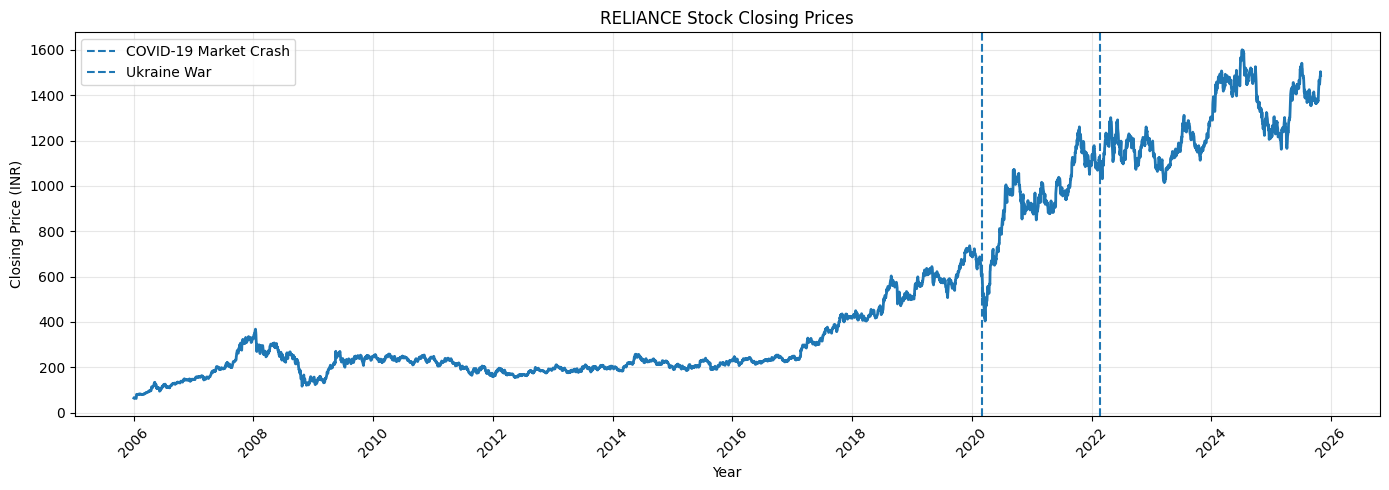

In [10]:
# Load visualization and data libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Read cleaned stock dataset
data_path = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_cleaned.csv"
stock_data = pd.read_csv(data_path)

# Select one stock for visualization
stock_name = "RELIANCE"
stock_prices = stock_data.loc[stock_data["Stock"] == stock_name].copy()

# Convert date column and sort chronologically
stock_prices["Date"] = pd.to_datetime(stock_prices["Date"])
stock_prices.sort_values("Date", inplace=True)

# Initialize plotting area
plt.figure(figsize=(14, 5))
sns.lineplot(
    x="Date",
    y="Close",
    data=stock_prices,
    linewidth=2
)

# Chart formatting
plt.title(f"{stock_name} Stock Closing Prices")
plt.xlabel("Year")
plt.ylabel("Closing Price (INR)")
plt.grid(alpha=0.3)

# X-axis formatting (every 2 years)
axis = plt.gca()
axis.xaxis.set_major_locator(mdates.YearLocator(base=2))
axis.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

# Highlight major market events
event_dates = {
    "COVID-19 Market Crash": "2020-03-01",
    "Ukraine War": "2022-02-24"
}

for label, date in event_dates.items():
    plt.axvline(pd.to_datetime(date), linestyle="--", linewidth=1.5, label=label)

# Display legend and layout
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
import ta
import matplotlib.pyplot as plt

# Load your preprocessed dataset
df = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_cleaned_final.csv")
df["Date"] = pd.to_datetime(df["Date"])

# Container for all indicator-enhanced data
enhanced_data = []

# Loop through each stock individually
for stock in df["Stock"].unique():
    stock_df = df[df["Stock"] == stock].copy()
    stock_df = stock_df.sort_values("Date")

    # Add technical indicators using `ta`
    stock_df["SMA_14"] = ta.trend.sma_indicator(stock_df["Close"], window=14)
    stock_df["EMA_14"] = ta.trend.ema_indicator(stock_df["Close"], window=14)
    stock_df["RSI_14"] = ta.momentum.rsi(stock_df["Close"], window=14)
    macd = ta.trend.macd(stock_df["Close"])
    stock_df["MACD"] = macd
    bb = ta.volatility.BollingerBands(close=stock_df["Close"], window=20, window_dev=2)
    stock_df["BB_High"] = bb.bollinger_hband()
    stock_df["BB_Low"] = bb.bollinger_lband()
    stock_df["ATR_14"] = ta.volatility.average_true_range(stock_df["High"], stock_df["Low"], stock_df["Close"], window=14)
    stock_df["Volume_SMA_14"] = ta.trend.sma_indicator(stock_df["Volume"], window=14)

    # Drop rows with NaNs caused by rolling indicators
    stock_df.dropna(inplace=True)

    # Append processed stock data
    enhanced_data.append(stock_df)

# Combine all processed stock data
df_final = pd.concat(enhanced_data, ignore_index=True)

# Save to file
output_path = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_indicators.csv"
df_final.to_csv(output_path, index=False)

print("Saving path of Technical indicators ", output_path)
print("Shape of dataset with indicators", df_final.shape)
df_final.head()

Saving path of Technical indicators  /Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_indicators.csv
Shape of dataset with indicators (1054104, 16)


,Date,Adj Close,Close,High,Low,Open,Volume,Stock,SMA_14,EMA_14,RSI_14,MACD,BB_High,BB_Low,ATR_14,Volume_SMA_14
0,2006-02-08,80.669418,88.966522,91.145378,88.243866,88.970154,800163.0,ABB,87.781246,86.432615,69.932397,4.458877,98.526256,68.407168,3.144599,778290.071429
1,2006-02-10,79.872566,88.087715,89.623810,86.791290,89.623810,360232.0,ABB,88.622182,86.653295,66.388441,4.205653,98.629246,69.788890,3.122307,765349.142857
2,2006-02-13,81.933830,90.360992,91.330582,88.134918,88.134918,1121248.0,ABB,89.235246,87.147655,70.546498,4.140674,98.759028,71.400200,3.130919,799491.142857
3,2006-02-14,81.942047,90.370071,92.238441,86.718658,86.718658,643475.0,ABB,89.759859,87.577311,70.562161,4.043302,98.547097,73.393712,3.301552,777596.571429
4,2006-02-15,81.833397,90.250237,91.982430,89.375053,90.313782,648729.0,ABB,89.766344,87.933701,70.032775,3.911376,98.084481,75.549486,3.251968,720325.571429


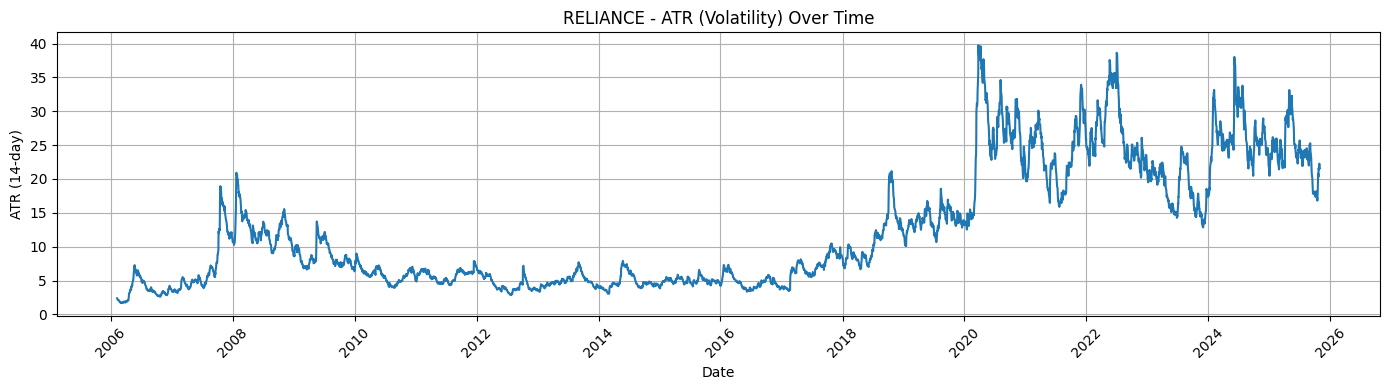

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset
file_path = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_indicators.csv"
df = pd.read_csv(file_path)

# Convert Date column
df["Date"] = pd.to_datetime(df["Date"])

# Select one stock
stock_name = "RELIANCE"
stock_data = df[df["Stock"] == stock_name].sort_values("Date")

# Plot ATR if available
if "ATR_14" in stock_data.columns:
    plt.figure(figsize=(14, 4))
    
    plt.plot(stock_data["Date"], stock_data["ATR_14"])
    plt.title(f"{stock_name} - ATR (Volatility) Over Time")
    plt.xlabel("Date")
    plt.ylabel("ATR (14-day)")
    color="#020247"
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("ATR_14 column not found in the dataset.")


In [16]:
import pandas as pd

# Read dataset
file_path = "/Users/somrajbharadwaj/project/final_data_science/venv/dataset/top250_indicators.csv"
data = pd.read_csv(file_path)

# Convert Date column
data["Date"] = pd.to_datetime(data["Date"])

train_rows = []
test_rows = []

# Split each stock by date (80% train, 20% test)
for stock in data["Stock"].unique():
    stock_data = data[data["Stock"] == stock].sort_values("Date")
    limit = int(len(stock_data) * 0.8)

    train_rows.append(stock_data.iloc[:limit])
    test_rows.append(stock_data.iloc[limit:])

# Combine all stocks
train_data = pd.concat(train_rows)
test_data = pd.concat(test_rows)

# Save results
train_data.to_csv("/Users/somrajbharadwaj/project/final_data_science/venv/train80.csv", index=False)
test_data.to_csv("/Users/somrajbharadwaj/project/final_data_science/venv/test20.csv", index=False)

print("Train/Test split completed successfully.")
print("Training data size:", train_data.shape)
print("Testing data size:", test_data.shape)


Train/Test split completed successfully.
Training data size: (843117, 16)
Testing data size: (210987, 16)


In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# File locations
train_file = "/Users/somrajbharadwaj/project/final_data_science/venv/train80.csv"
test_file  = "/Users/somrajbharadwaj/project/final_data_science/venv/test20.csv"

# Load data
train_df = pd.read_csv(train_file)
test_df  = pd.read_csv(test_file)

# Convert date column
train_df["Date"] = pd.to_datetime(train_df["Date"], errors="coerce")
test_df["Date"]  = pd.to_datetime(test_df["Date"], errors="coerce")

# Feature columns
feat_cols = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]

# Next-day prediction label (supervised target)
train_df["NextClose"] = train_df.groupby("Stock")["Close"].shift(-1)
test_df["NextClose"]  = test_df.groupby("Stock")["Close"].shift(-1)

# Remove incomplete rows
train_df = train_df.dropna(subset=feat_cols + ["NextClose"])
test_df  = test_df.dropna(subset=feat_cols + ["NextClose"])

# Prepare inputs and outputs
X_tr = train_df[feat_cols]
y_tr = train_df["NextClose"]

X_te = test_df[feat_cols]
y_te = test_df["NextClose"]

# Train Random Forest model (baseline)
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_regressor.fit(X_tr, y_tr)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

Random Forest Performance (Test Set)
RMSE : 3420.91
MAE  : 292.73
R²   : 0.9116


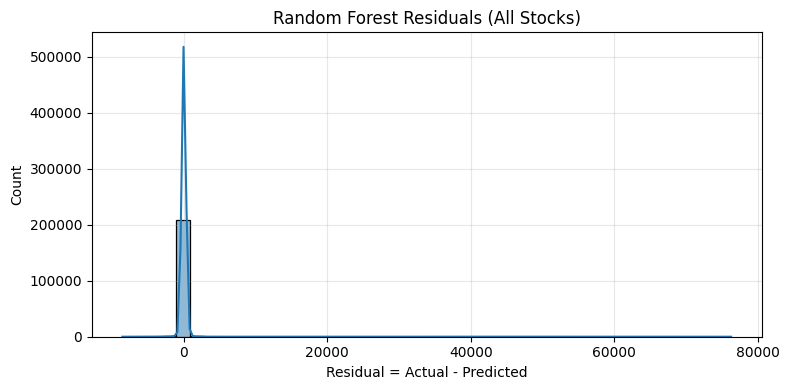

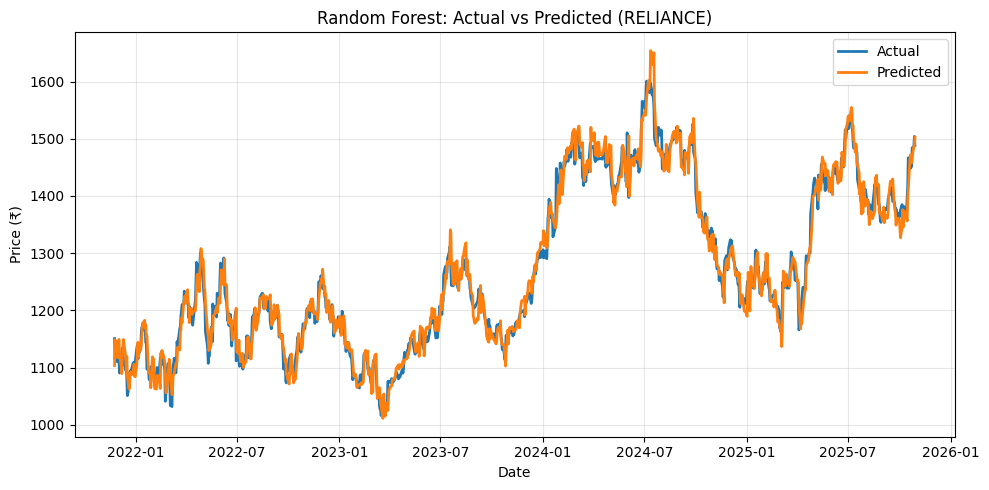

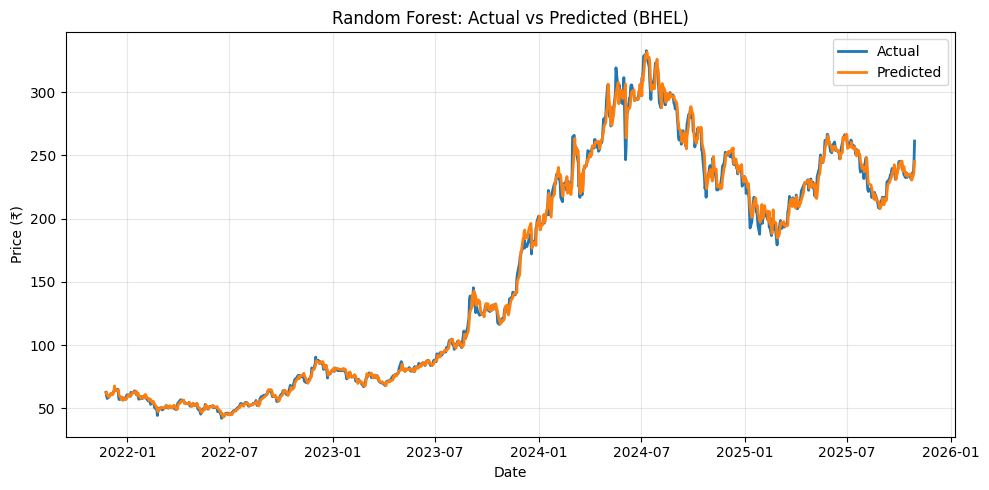

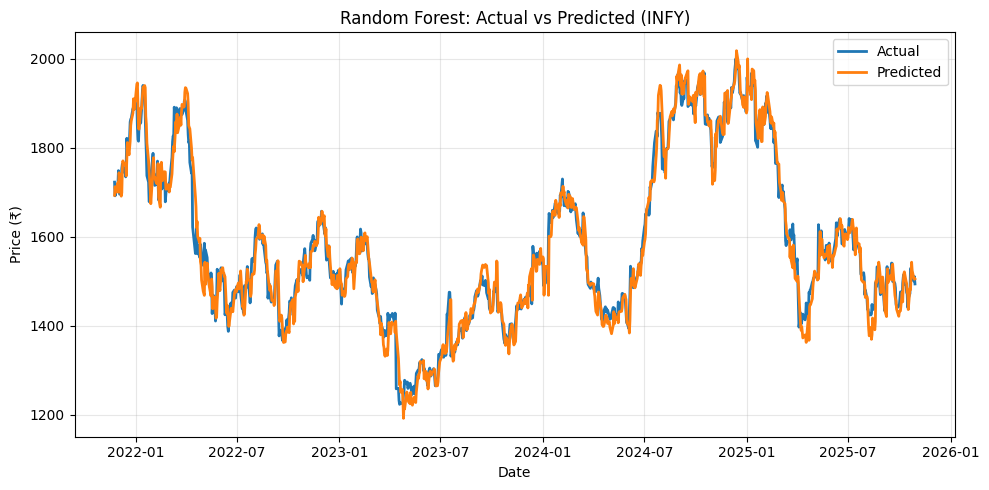

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on test set

y_hat = rf_regressor.predict(X_te)

# Compute evaluation metrics
mse_val = mean_squared_error(y_te, y_hat)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_te, y_hat)
r2_val = r2_score(y_te, y_hat)

print("Random Forest Performance (Test Set)")
print(f"RMSE : {rmse_val:.2f}")
print(f"MAE  : {mae_val:.2f}")
print(f"R²   : {r2_val:.4f}")


# Store for later comparison
rf_rmse, rf_mae, rf_r2 = rmse_val, mae_val, r2_val


#  Residual distribution
err = y_te - y_hat

plt.figure(figsize=(8, 4))
sns.histplot(err, bins=45, kde=True)
plt.title("Random Forest Residuals (All Stocks)")
plt.xlabel("Residual = Actual - Predicted")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Actual vs Predicted per stock
def view_stock_fit(stock_code, trained_model, df_test, cols):
    part = df_test[df_test["Stock"] == stock_code].copy()
    part = part.dropna(subset=cols + ["NextClose", "Date"]).sort_values("Date")

    if part.empty:
        print(f"Skipping {stock_code}: no usable rows.")
        return

    y_true = part["NextClose"].values
    y_pred = trained_model.predict(part[cols])

    plt.figure(figsize=(10, 5))
    plt.plot(part["Date"], y_true, label="Actual", linewidth=2)
    plt.plot(part["Date"], y_pred, label="Predicted", linewidth=2)
    plt.title(f"Random Forest: Actual vs Predicted ({stock_code})")
    plt.xlabel("Date")
    plt.ylabel("Price (₹)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Show examples
view_stock_fit("RELIANCE", rf_regressor, test_df, feat_cols)
view_stock_fit("BHEL", rf_regressor, test_df, feat_cols)
view_stock_fit("INFY", rf_regressor, test_df, feat_cols)


        Date  Predicted_Close
0 2025-10-31      1509.010828
1 2025-11-03      1520.313246
2 2025-11-04      1528.253424
3 2025-11-05      1544.833865
4 2025-11-06      1548.543624

Saved: rf_next_14_days_forecast.csv


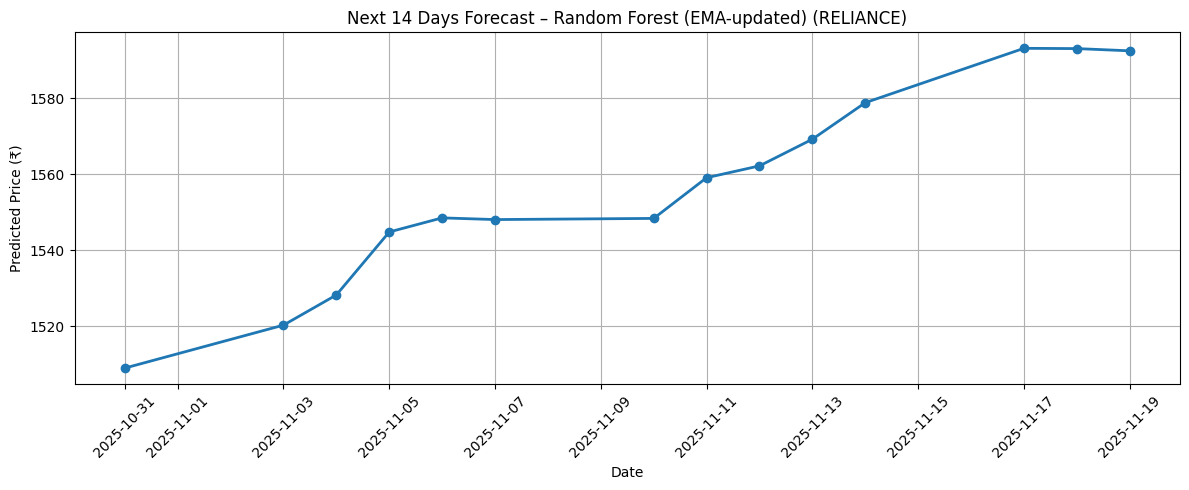

In [21]:
# NEXT 14 DAYS FORECAST 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Load train/test data

train_path = "/Users/somrajbharadwaj/project/final_data_science/venv/train80.csv"
test_path  = "/Users/somrajbharadwaj/project/final_data_science/venv/test20.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

train["Date"], test["Date"] = pd.to_datetime(train["Date"]), pd.to_datetime(test["Date"])

# Features (must match training)

features = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]

# Create next-day target (supervised learning)

train["Target"] = train.groupby("Stock")["Close"].shift(-1)
test["Target"]  = test.groupby("Stock")["Close"].shift(-1)  # optional (not used for future forecast)

# drop null data
train = train.dropna(subset=features + ["Target"]).copy()
test  = test.dropna(subset=features).copy()  # Target not required for future forecast

X_train = train[features]
y_train = train["Target"]

#  Train Random Forest

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

#  Pick stock & get last known feature row from that stock

stock_symbol = "RELIANCE"   # select any share name 

stock_df = test[test["Stock"] == stock_symbol].sort_values("Date").copy()
if stock_df.empty:
    raise ValueError(f"No rows found for stock_symbol='{stock_symbol}'. Check test['Stock'].unique().")

last_row = stock_df.iloc[-1]
last_date = last_row["Date"]

# Create next 14 business days (trading-day approximation)

future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=14)

#  Recursive forecast with EMA update

alpha = 2 / (14 + 1)  # EMA smoothing factor

current_features = last_row[features].copy()
ema = float(current_features["EMA_14"])

future_predictions = []

for d in future_dates:
    # keep as DataFrame with proper feature names (removes sklearn warning)
    X_future = pd.DataFrame([current_features], columns=features)

    next_close = float(model.predict(X_future)[0])

    future_predictions.append({
        "Date": d,
        "Predicted_Close": next_close
    })

    # Update EMA using predicted close (makes forecast non-flat)
    ema = alpha * next_close + (1 - alpha) * ema
    current_features["EMA_14"] = ema

# Forecast DataFrame and save

future_df = pd.DataFrame(future_predictions)
future_df.to_csv("rf_next_14_days_forecast.csv", index=False)

print(future_df.head())
print("\nSaved: rf_next_14_days_forecast.csv")

#  Plot: Next 14 predicted only

plt.figure(figsize=(12, 5))
plt.plot(future_df["Date"], future_df["Predicted_Close"], marker="o", linewidth=2)
plt.title(f"Next 14 Days Forecast – Random Forest (EMA-updated) ({stock_symbol})")
plt.xlabel("Date")
plt.ylabel("Predicted Price (₹)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
import os
import joblib
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# Load training dataset

train_file = "/Users/somrajbharadwaj/project/final_data_science/venv/train80.csv"
train_df = pd.read_csv(train_file)

#  Define inputs + next-day target

cols = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]

train_df["NextClose"] = train_df.groupby("Stock")["Close"].shift(-1)
train_df = train_df.dropna(subset=cols + ["NextClose"]).copy()

X = train_df[cols]
y = train_df["NextClose"]


#  Time-series cross-validation
cv_splitter = TimeSeriesSplit(n_splits=3)

#  Parameter sampling space (kept small for speed)

search_space = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"],
    "bootstrap": [True, False],
}

#  Load tuned model if available; otherwise tune + save

save_path = "/Users/somrajbharadwaj/project/final_data_science/venv/rftuned.pkl"

if os.path.isfile(save_path):
    tuned_rf = joblib.load(save_path)
    print("Loaded tuned Random Forest model from disk:", save_path)
else:
    base_rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    tuner = RandomizedSearchCV(
        estimator=base_rf,
        param_distributions=search_space,
        n_iter=20,
        cv=cv_splitter,
        scoring="neg_mean_squared_error",
        verbose=2,
        random_state=42
    )

    tuner.fit(X, y)
    tuned_rf = tuner.best_estimator_

    joblib.dump(tuned_rf, save_path)
    print("Saved tuned Random Forest model to:", save_path)

print("Best parameters:", tuned_rf.get_params())


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  11.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  22.8s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  47.4s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.5s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.7s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimat


Random Forest results for RELIANCE (2021–2025)
RMSE = 21.83
MAE  = 16.80
R²   = 0.9758


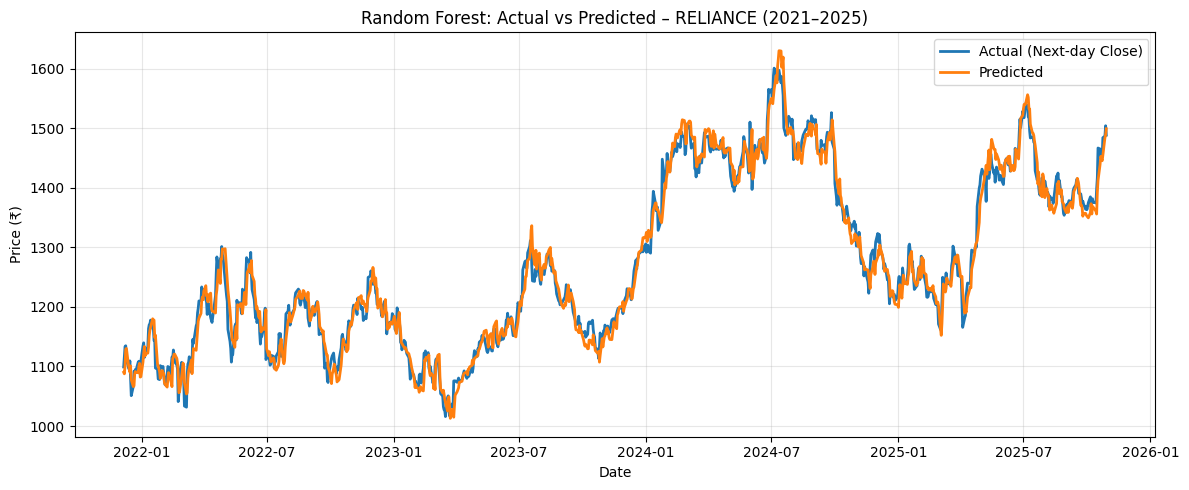


Random Forest results for INFY (2021–2025)
RMSE = 32.51
MAE  = 24.14
R²   = 0.9686


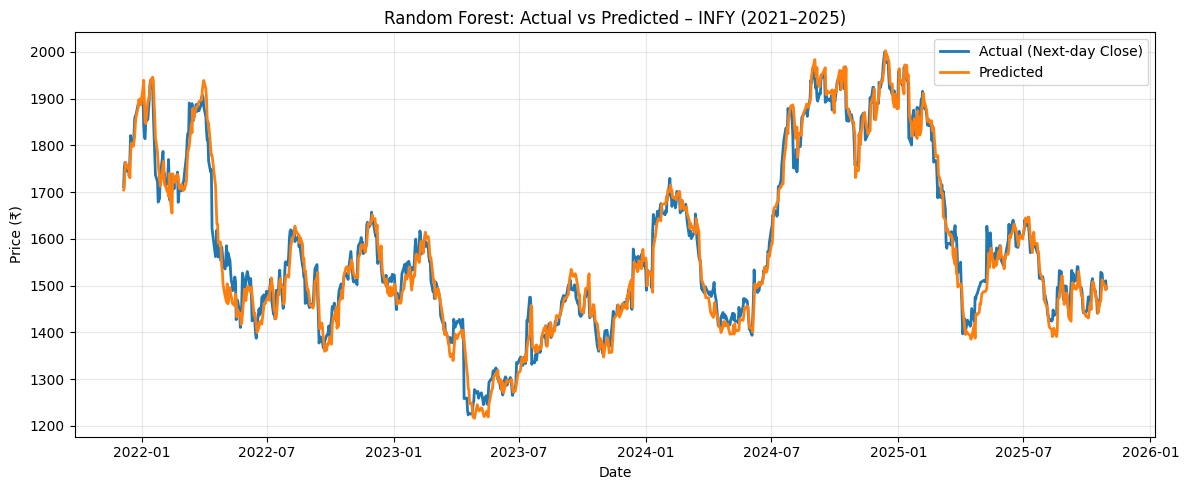


Random Forest results for BHEL (2021–2025)
RMSE = 5.50
MAE  = 3.50
R²   = 0.9962


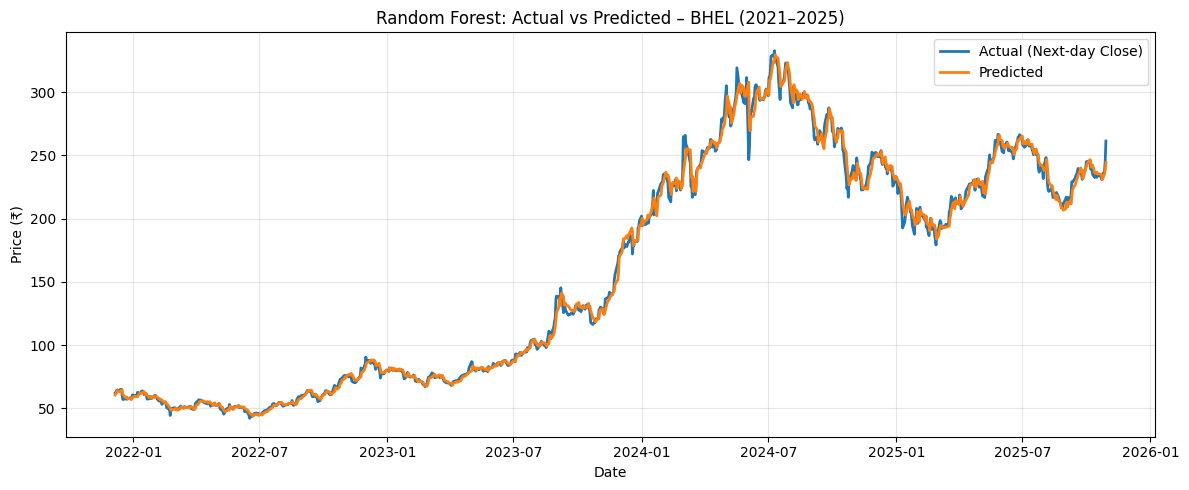


Saved metrics table to: /Users/somrajbharadwaj/project/final_data_science/venv/rf_stock_metrics.csv


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Load test data

test_file = "/Users/somrajbharadwaj/project/final_data_science/venv/test20.csv"
df_test = pd.read_csv(test_file)

df_test["Date"] = pd.to_datetime(df_test["Date"], errors="coerce")

# Feature columns (must match training)
feat_cols = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]

# Create next-day label for evaluation
df_test["NextClose"] = df_test.groupby("Stock")["Close"].shift(-1)

# Keep only valid rows and apply date window
df_test = df_test.dropna(subset=feat_cols + ["NextClose", "Date"]).copy()
df_test = df_test[(df_test["Date"] >= "2021-12-06") & (df_test["Date"] <= "2025-11-27")].copy()

# Load trained model

rf_path = "/Users/somrajbharadwaj/project/final_data_science/venv/rftuned.pkl"
rf = joblib.load(rf_path)

# Stocks to report
watchlist = ["RELIANCE", "INFY", "BHEL"]

results = []

# Evaluate per stock
for sym in watchlist:
    one = df_test[df_test["Stock"] == sym].sort_values("Date").copy()

    if one.empty:
        print(f"{sym}: no rows available in selected date range.")
        continue

    X_eval = one[feat_cols]
    y_true = one["NextClose"].values
    y_pred = rf.predict(X_eval)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\nRandom Forest results for {sym} (2021–2025)")
    print(f"RMSE = {rmse:.2f}")
    print(f"MAE  = {mae:.2f}")
    print(f"R²   = {r2:.4f}")

    results.append({
        "Stock": sym,
        "Model": "Random Forest",
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R2_Score": round(r2, 4)
    })

    # 4) Plot actual vs predicted
  
    plt.figure(figsize=(12, 5))
    plt.plot(one["Date"], y_true, label="Actual (Next-day Close)", linewidth=2)
    plt.plot(one["Date"], y_pred, label="Predicted", linewidth=2)
    plt.title(f"Random Forest: Actual vs Predicted – {sym} (2021–2025)")
    plt.xlabel("Date")
    plt.ylabel("Price (₹)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    fig_path = f"/Users/somrajbharadwaj/project/final_data_science/venv/rf_actual_vs_pred_{sym}.png"
    plt.savefig(fig_path, dpi=200)
    plt.show()


# Save metrics table
metrics_df = pd.DataFrame(results)
metrics_out = "/Users/somrajbharadwaj/project/final_data_science/venv/rf_stock_metrics.csv"
metrics_df.to_csv(metrics_out, index=False)

print(f"\nSaved metrics table to: {metrics_out}")


XGBOOST

XGBoost Performance (Test Set)
RMSE : 5236.37
MAE  : 590.81
R²   : 0.7930


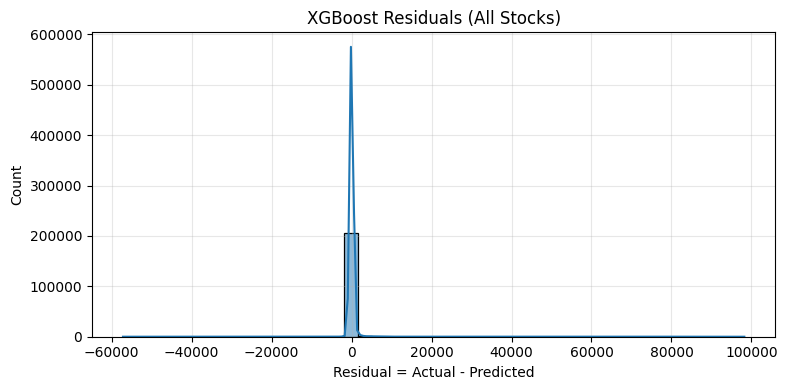

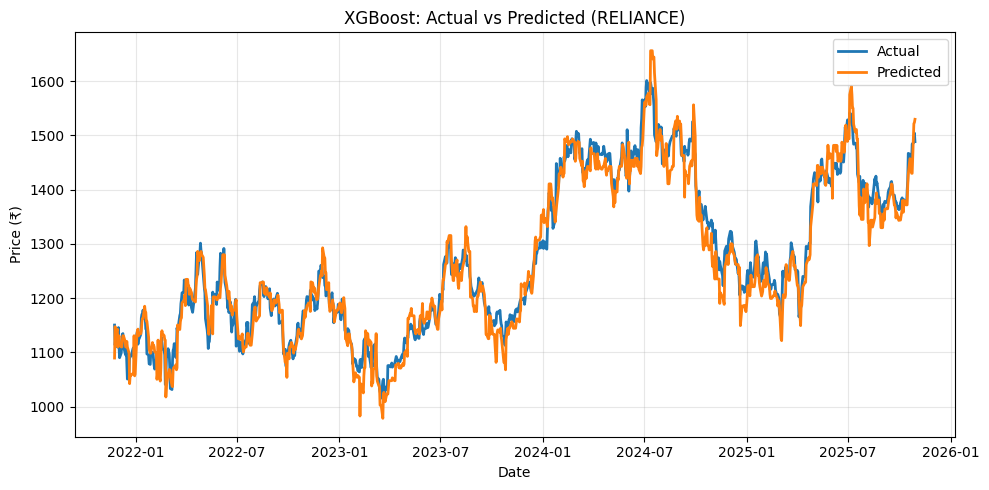

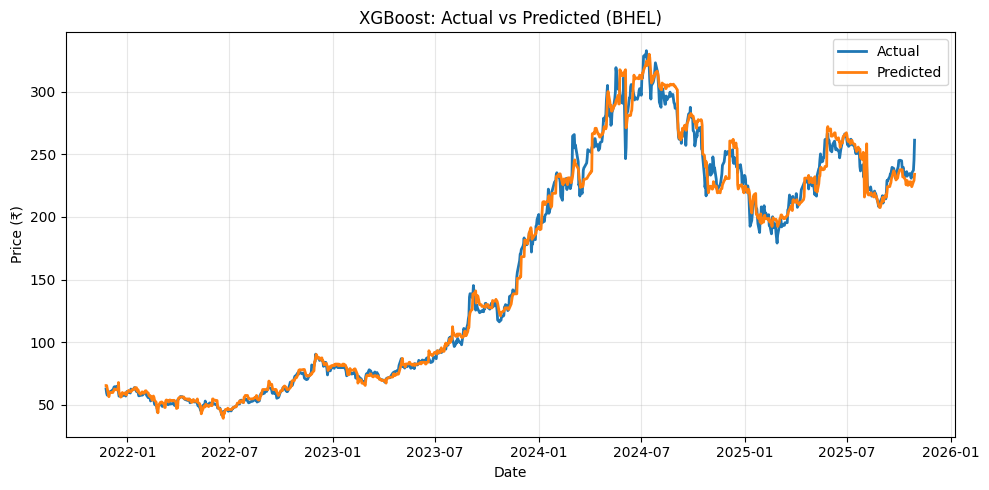

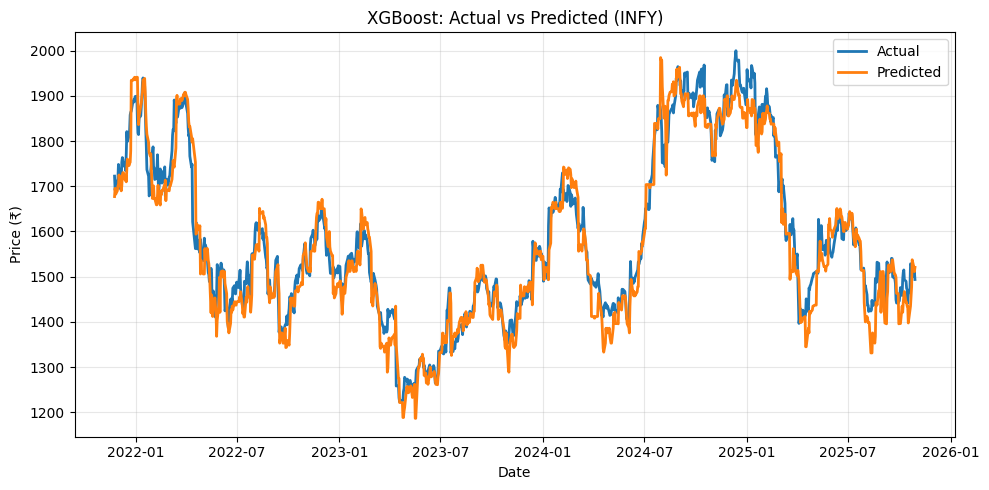

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load train/test files

train_path = "/Users/somrajbharadwaj/project/final_data_science/venv/train80.csv"
test_path  = "/Users/somrajbharadwaj/project/final_data_science/venv/test20.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

train_df["Date"] = pd.to_datetime(train_df["Date"], errors="coerce")
test_df["Date"]  = pd.to_datetime(test_df["Date"], errors="coerce")

# Feature set + next-day target

feat_cols = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]

train_df["NextClose"] = train_df.groupby("Stock")["Close"].shift(-1)
test_df["NextClose"]  = test_df.groupby("Stock")["Close"].shift(-1)

train_df = train_df.dropna(subset=feat_cols + ["NextClose"]).copy()
test_df  = test_df.dropna(subset=feat_cols + ["NextClose"]).copy()

X_tr = train_df[feat_cols]
y_tr = train_df["NextClose"]

X_te = test_df[feat_cols]
y_te = test_df["NextClose"]

# Train XGBoost model

xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.10,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_tr, y_tr)

# Predict + evaluate

y_hat = xgb.predict(X_te)

rmse_val = np.sqrt(mean_squared_error(y_te, y_hat))
mae_val  = mean_absolute_error(y_te, y_hat)
r2_val   = r2_score(y_te, y_hat)

print("XGBoost Performance (Test Set)")
print(f"RMSE : {rmse_val:.2f}")
print(f"MAE  : {mae_val:.2f}")
print(f"R²   : {r2_val:.4f}")

# Save for comparison
xgb_rmse, xgb_mae, xgb_r2 = rmse_val, mae_val, r2_val

# Residual distribution

errors = y_te - y_hat
plt.figure(figsize=(8, 4))
sns.histplot(errors, bins=45, kde=True)
plt.title("XGBoost Residuals (All Stocks)")
plt.xlabel("Residual = Actual - Predicted")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Visual check per stock
def show_fit(symbol, trained_model, frame, cols):
    sub = frame.loc[frame["Stock"] == symbol].copy()
    sub = sub.dropna(subset=cols + ["NextClose", "Date"]).sort_values("Date")

    if sub.empty:
        print(f"{symbol}: no valid rows found.")
        return

    y_true = sub["NextClose"].values
    y_pred = trained_model.predict(sub[cols])

    plt.figure(figsize=(10, 5))
    plt.plot(sub["Date"], y_true, label="Actual", linewidth=2)
    plt.plot(sub["Date"], y_pred, label="Predicted", linewidth=2)
    plt.title(f"XGBoost: Actual vs Predicted ({symbol})")
    plt.xlabel("Date")
    plt.ylabel("Price (₹)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Examples
for s in ["RELIANCE", "BHEL", "INFY"]:
    show_fit(s, xgb, test_df, feat_cols)


In [26]:
import os
import joblib
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# Load training dataset

train_file = "/Users/somrajbharadwaj/project/final_data_science/venv/train80.csv"
df = pd.read_csv(train_file)


#  Prepare features + next-day label
cols = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]

df["NextClose"] = df.groupby("Stock")["Close"].shift(-1)
df = df.dropna(subset=cols + ["NextClose"]).copy()

X = df[cols]
y = df["NextClose"]

# Time-series cross-validation setup

time_cv = TimeSeriesSplit(n_splits=3)

# Parameter search space (kept moderate for runtime)

xgb_space = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.10, 0.20],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

# Tune or load from disk

save_model = "/Users/somrajbharadwaj/project/final_data_science/venv/xgb_tuned.pkl"

if os.path.isfile(save_model):
    tuned_xgb = joblib.load(save_model)
    print("Loaded tuned XGBoost model:", save_model)
else:
    base_model = XGBRegressor(random_state=42, n_jobs=-1)

    tuner = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=xgb_space,
        n_iter=20,
        cv=time_cv,
        scoring="neg_mean_squared_error",
        verbose=2,
        random_state=42
    )

    tuner.fit(X, y)
    tuned_xgb = tuner.best_estimator_
    joblib.dump(tuned_xgb, save_model)

    print("Saved tuned XGBoost model:", save_model)

print("XGBoost tuning complete. Best parameters:")
print(tuned_xgb.get_params())


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END colsamp


XGBoost Evaluation – RELIANCE (2021–2025)
RMSE = 48.30
MAE  = 38.86
R²   = 0.8814


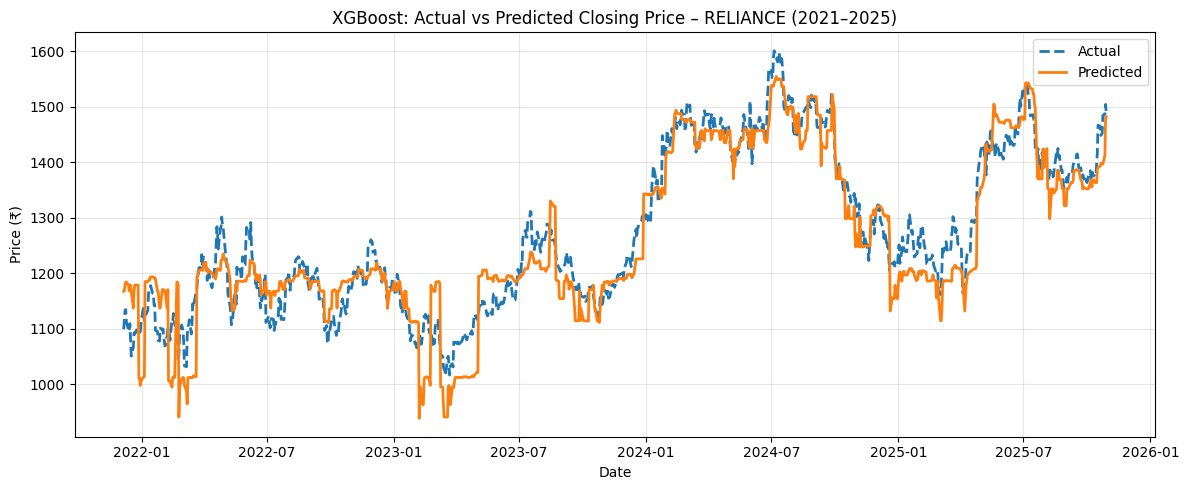


XGBoost Evaluation – INFY (2021–2025)
RMSE = 69.30
MAE  = 54.80
R²   = 0.8575


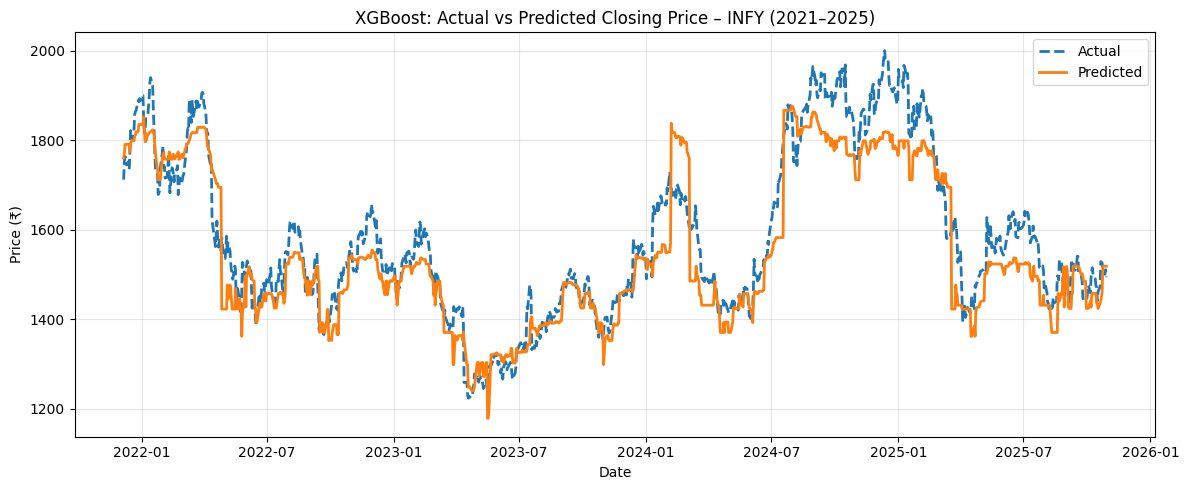


XGBoost Evaluation – BHEL (2021–2025)
RMSE = 8.88
MAE  = 6.36
R²   = 0.9901


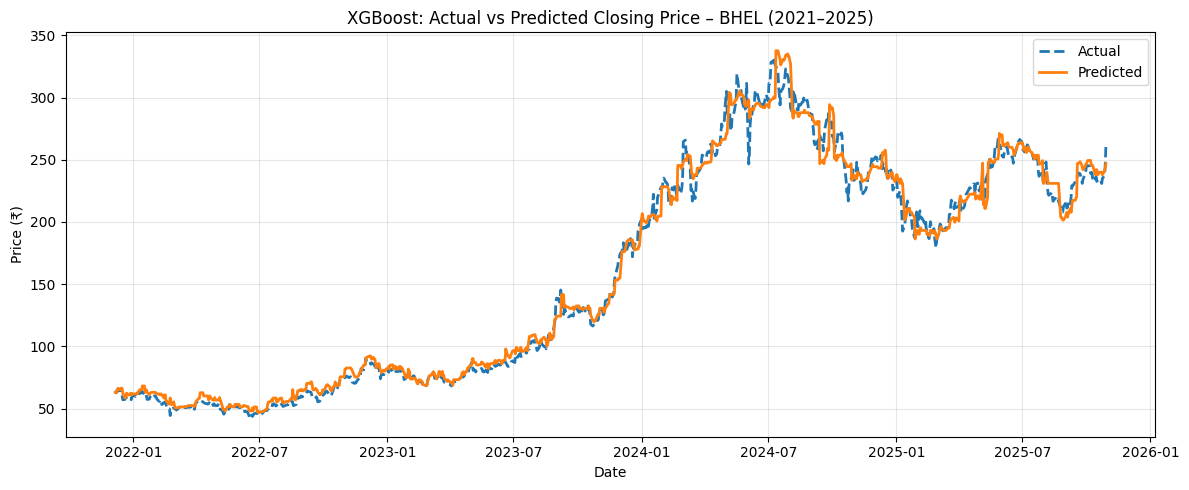


Saved XGBoost metrics to: /Users/somrajbharadwaj/project/final_data_science/venv/xgb_metrics.csv


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load test data

test_file = "/Users/somrajbharadwaj/project/final_data_science/venv/test20.csv"
df_test = pd.read_csv(test_file)

df_test["Date"] = pd.to_datetime(df_test["Date"], errors="coerce")

# Feature set used in training
feat_cols = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]

# Next-day target for evaluation
df_test["NextClose"] = df_test.groupby("Stock")["Close"].shift(-1)

# Keep valid rows + apply evaluation date range
df_test = df_test.dropna(subset=feat_cols + ["NextClose", "Date"]).copy()
df_test = df_test[(df_test["Date"] >= "2021-12-06") & (df_test["Date"] <= "2025-11-27")].copy()


#  Load tuned XGBoost model
model_path = "/Users/somrajbharadwaj/project/final_data_science/venv/xgb_tuned.pkl"
xgb = joblib.load(model_path)

# Stocks to report
stocks_to_check = ["RELIANCE", "INFY", "BHEL"]

rows = []

# Evaluate + plot per stock

for symbol in stocks_to_check:
    part = df_test[df_test["Stock"] == symbol].sort_values("Date").copy()

    if part.empty:
        print(f"{symbol}: no usable rows in selected period.")
        continue

    X_eval = part[feat_cols]
    y_true = part["NextClose"].values
    y_pred = xgb.predict(X_eval)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\nXGBoost Evaluation – {symbol} (2021–2025)")
    print(f"RMSE = {rmse:.2f}")
    print(f"MAE  = {mae:.2f}")
    print(f"R²   = {r2:.4f}")

    rows.append({
        "Stock": symbol,
        "Model": "XGBoost",
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R2_Score": round(r2, 4)
    })

    # Actual vs Predicted plot
    plt.figure(figsize=(12, 5))
    plt.plot(part["Date"], y_true, linestyle="--", linewidth=2, label="Actual")
    plt.plot(part["Date"], y_pred, linewidth=2, label="Predicted")

    plt.title(f"XGBoost: Actual vs Predicted Closing Price – {symbol} (2021–2025)")
    plt.xlabel("Date")
    plt.ylabel("Price (₹)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    fig_out = f"/Users/somrajbharadwaj/project/final_data_science/venv/xgb_actual_vs_pred_{symbol}.png"
    plt.savefig(fig_out, dpi=200)
    plt.show()

# Save metrics table once

metrics_df = pd.DataFrame(rows)
metrics_csv = "/Users/somrajbharadwaj/project/final_data_science/venv/xgb_metrics.csv"
metrics_df.to_csv(metrics_csv, index=False)

print(f"\nSaved XGBoost metrics to: {metrics_csv}")



Decision Tree (Baseline) – HDFCBANK
RMSE = 26.55
MAE  = 20.98
R²   = 0.9100


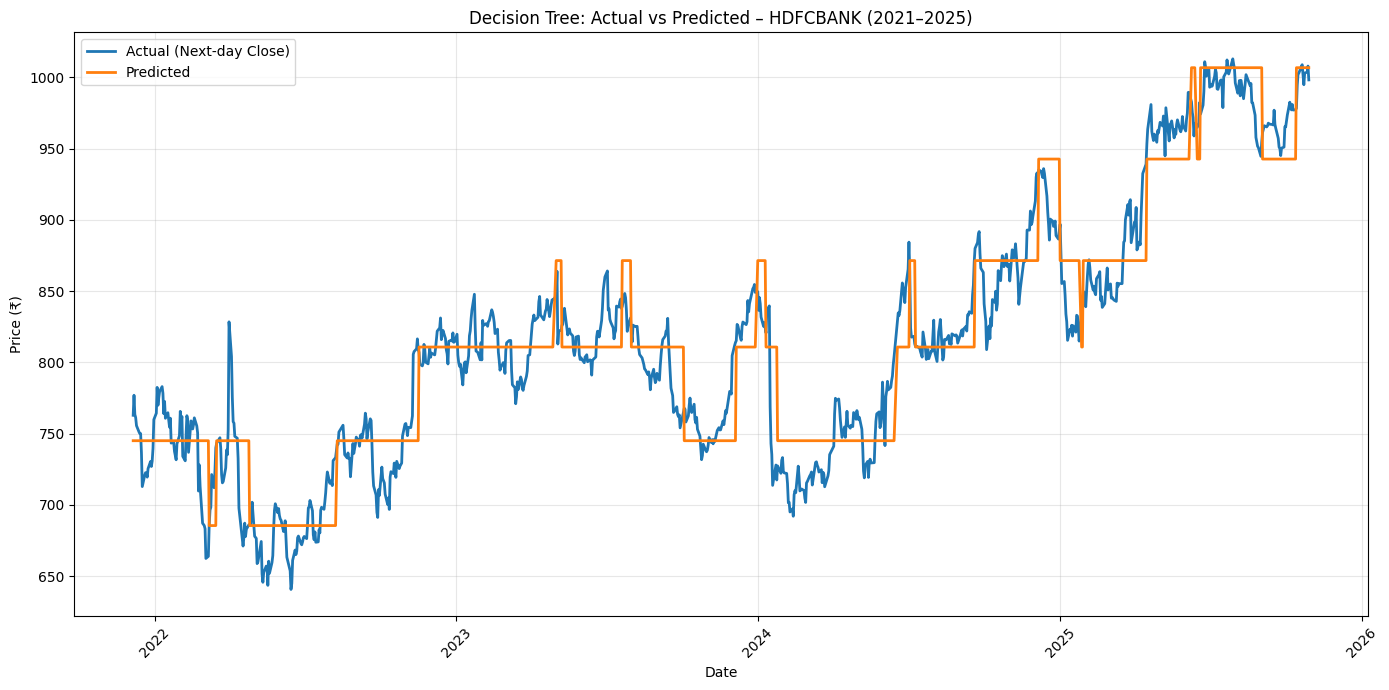

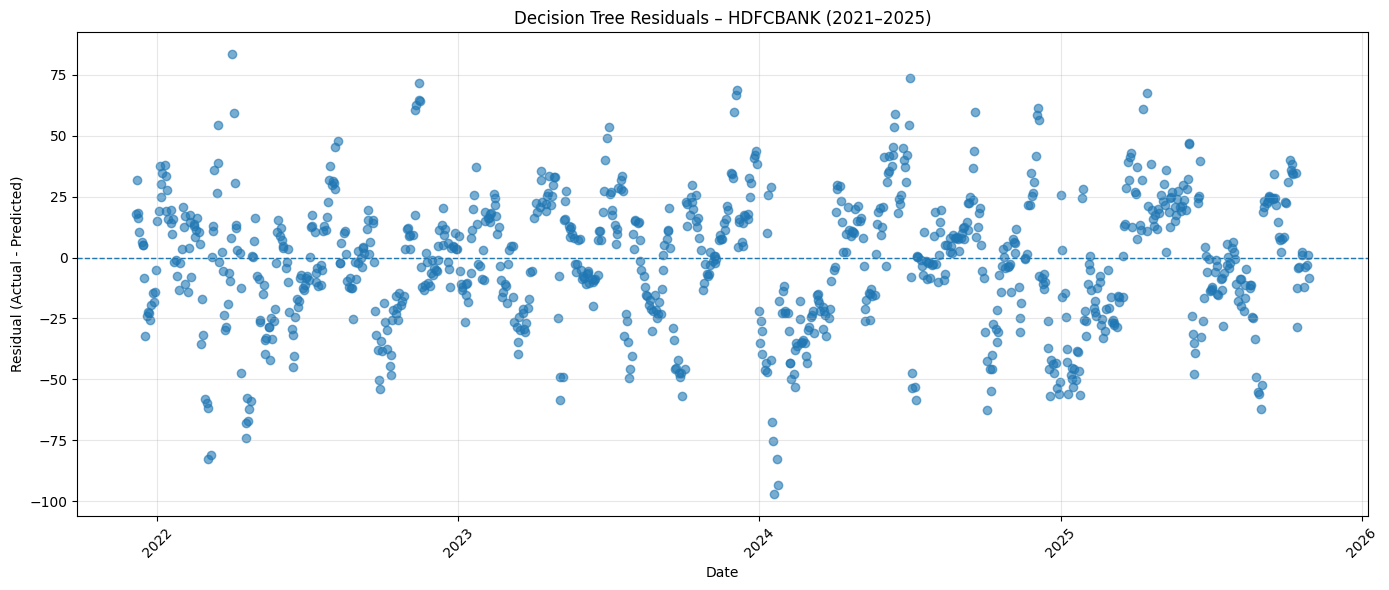


Decision Tree (Baseline) – BHEL
RMSE = 16.44
MAE  = 13.00
R²   = 0.9659


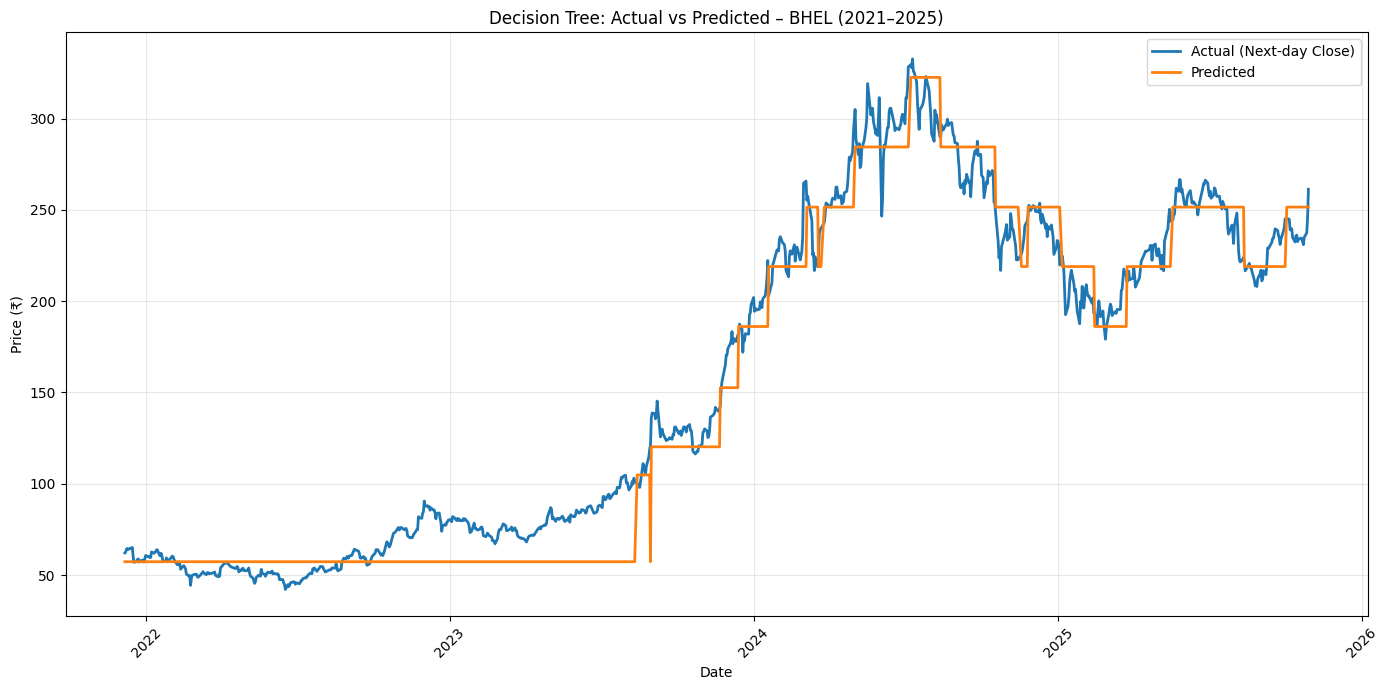

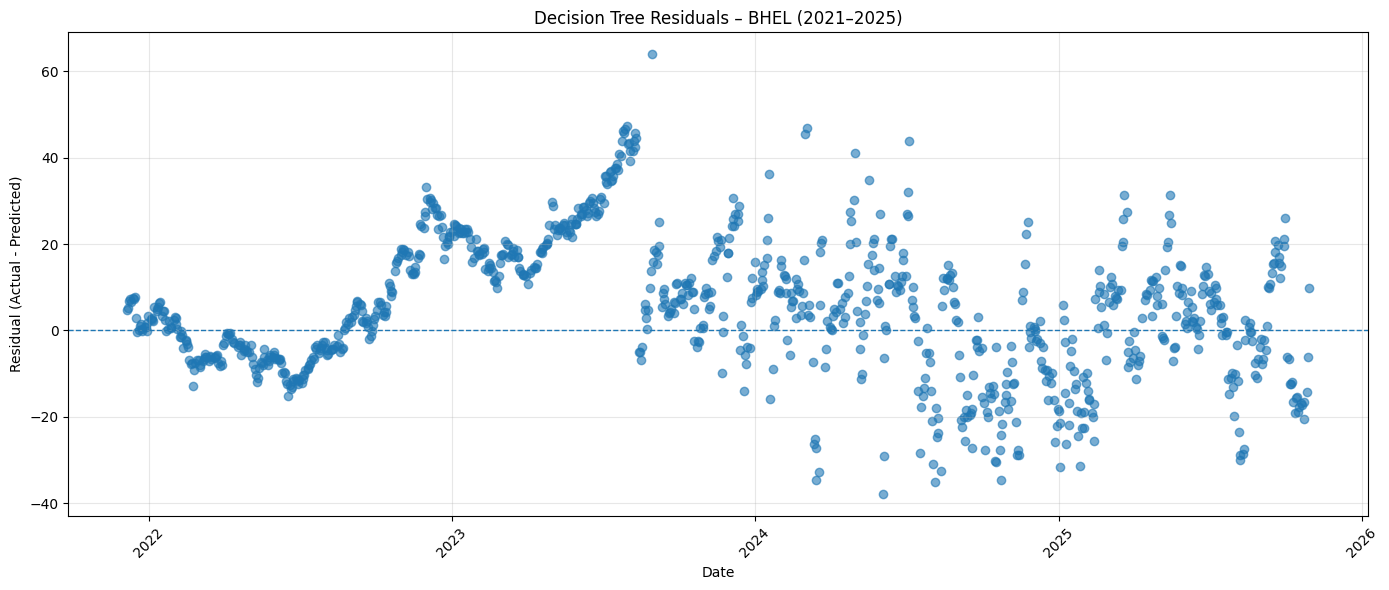


Decision Tree metrics saved to: /Users/somrajbharadwaj/project/final_data_science/venv/dtree_outputs/decision_tree_metrics.csv


In [29]:
#importing necessary libraries
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# File locations

train_file = "/Users/somrajbharadwaj/project/final_data_science/venv/train80.csv"
test_file  = "/Users/somrajbharadwaj/project/final_data_science/venv/test20.csv"

save_folder = "/Users/somrajbharadwaj/project/final_data_science/venv/dtree_outputs"
os.makedirs(save_folder, exist_ok=True)

watch_stocks = ["HDFCBANK", "BHEL"]

indicator_cols = ["SMA_14", "EMA_14", "RSI_14", "MACD", "BB_High", "BB_Low", "ATR_14", "Volume_SMA_14"]


# Load datasets + prepare dates

train_data = pd.read_csv(train_file)
test_data  = pd.read_csv(test_file)

train_data["Date"] = pd.to_datetime(train_data["Date"], errors="coerce")
test_data["Date"]  = pd.to_datetime(test_data["Date"], errors="coerce")

# Create next-day label
train_data["NextClose"] = train_data.groupby("Stock")["Close"].shift(-1)
test_data["NextClose"]  = test_data.groupby("Stock")["Close"].shift(-1)

# Keep rows with complete info
train_data = train_data.dropna(subset=indicator_cols + ["NextClose"]).copy()
test_data  = test_data.dropna(subset=indicator_cols + ["NextClose"]).copy()

# Scale indicators (fit on train only)

scale = MinMaxScaler()
X_tr = scale.fit_transform(train_data[indicator_cols])
y_tr = train_data["NextClose"].values

# Train Decision Tree (baseline)

tree_model = DecisionTreeRegressor(
    max_depth=8,
    min_samples_split=12,
    min_samples_leaf=6,
    random_state=44
)
tree_model.fit(X_tr, y_tr)

# Save fitted model and scaler
joblib.dump(tree_model, os.path.join(save_folder, "dt_model.pkl"))
joblib.dump(scale, os.path.join(save_folder, "dt_scaler.pkl"))

# Evaluate and plot per stock

summary_rows = []

for s in watch_stocks:
    one_stock = test_data.loc[test_data["Stock"] == s].sort_values("Date").copy()

    # Consistent evaluation window
    one_stock = one_stock[(one_stock["Date"] >= "2021-12-06") & (one_stock["Date"] <= "2025-10-29")].copy()
    one_stock = one_stock.dropna(subset=indicator_cols + ["NextClose"])

    if one_stock.empty:
        print(f"{s}: no usable rows in the selected period.")
        continue

    X_eval = scale.transform(one_stock[indicator_cols])
    y_true = one_stock["NextClose"].values
    y_pred = tree_model.predict(X_eval)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    print(f"\nDecision Tree (Baseline) – {s}")
    print(f"RMSE = {rmse:.2f}")
    print(f"MAE  = {mae:.2f}")
    print(f"R²   = {r2:.4f}")

    summary_rows.append({
        "Stock": s,
        "Model": "Decision Tree",
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R2_Score": round(r2, 4)
    })

    # Plot: Actual vs Predicted
    plt.figure(figsize=(14, 7))
    plt.plot(one_stock["Date"], y_true, label="Actual (Next-day Close)", linewidth=2)
    plt.plot(one_stock["Date"], y_pred, label="Predicted", linewidth=2)
    plt.title(f"Decision Tree: Actual vs Predicted – {s} (2021–2025)")
    plt.xlabel("Date")
    plt.ylabel("Price (₹)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(save_folder, f"dt_actual_vs_pred_{s}.png"), dpi=200)
    plt.show()

    # ---- Plot: Residuals over time
    res = y_true - y_pred
    plt.figure(figsize=(14, 6))
    plt.scatter(one_stock["Date"], res, alpha=0.6)
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.title(f"Decision Tree Residuals – {s} (2021–2025)")
    plt.xlabel("Date")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.grid(alpha=0.3)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(save_folder, f"dt_residuals_{s}.png"), dpi=200)
    plt.show()

# Save metrics table

metrics_table = pd.DataFrame(summary_rows)
metrics_file = os.path.join(save_folder, "decision_tree_metrics.csv")
metrics_table.to_csv(metrics_file, index=False)

print(f"\nDecision Tree metrics saved to: {metrics_file}")


      Stock          Model   RMSE    MAE  R2_Score
0  RELIANCE  Random Forest  21.83  16.80    0.9758
1      INFY  Random Forest  32.51  24.14    0.9686
2      BHEL  Random Forest   5.50   3.50    0.9962
3  RELIANCE        XGBoost  48.30  38.86    0.8814
4      INFY        XGBoost  69.30  54.80    0.8575
5      BHEL        XGBoost   8.88   6.36    0.9901
6  HDFCBANK  Decision Tree  26.55  20.98    0.9100
7      BHEL  Decision Tree  16.44  13.00    0.9659

Model-level average performance:
           Model       RMSE        MAE  R2_Score
0  Decision Tree  21.495000  16.990000  0.937950
1  Random Forest  19.946667  14.813333  0.980200
2        XGBoost  42.160000  33.340000  0.909667


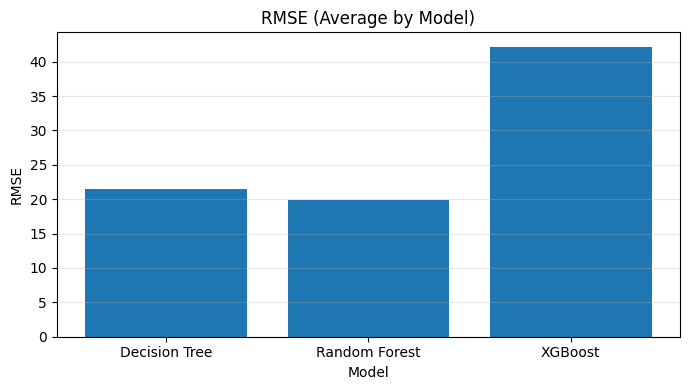

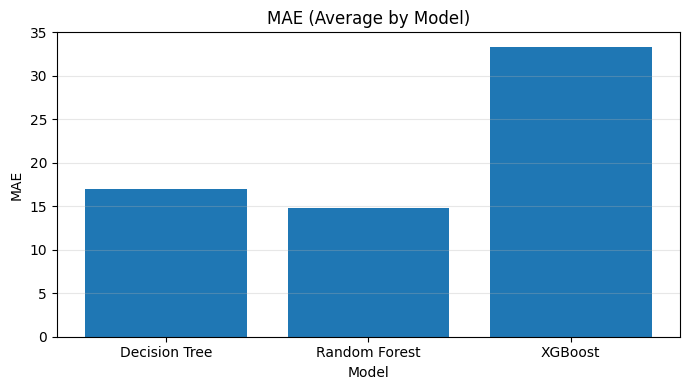

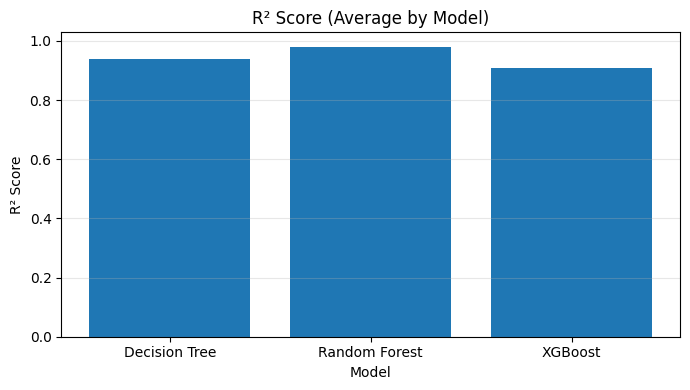

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Read metrics files
# -----------------------------
rf_path  = "/Users/somrajbharadwaj/project/final_data_science/venv/rf_stock_metrics.csv"
xgb_path = "/Users/somrajbharadwaj/project/final_data_science/venv/xgb_metrics.csv"
dt_path  = "/Users/somrajbharadwaj/project/final_data_science/venv/dtree_outputs/decision_tree_metrics.csv"

rf_df  = pd.read_csv(rf_path)
xgb_df = pd.read_csv(xgb_path)
dt_df  = pd.read_csv(dt_path)


# 2) Merge all results

metrics = pd.concat([rf_df, xgb_df, dt_df], ignore_index=True)

# Make sure R2 column name is consistent
if "R2_Score" not in metrics.columns and "R2" in metrics.columns:
    metrics["R2_Score"] = metrics["R2"]

if "R2" in metrics.columns and "R2_Score" in metrics.columns:
    metrics["R2_Score"] = metrics["R2_Score"].fillna(metrics["R2"])
    metrics = metrics.drop(columns=["R2"])

print(metrics)

#  Create model-level summary (average across stocks)

model_summary = (
    metrics.groupby("Model", as_index=False)
           .agg(RMSE=("RMSE", "mean"),
                MAE=("MAE", "mean"),
                R2_Score=("R2_Score", "mean"))
)

print("\nModel-level average performance:")
print(model_summary)

# Plot (3 separate charts)

plt.figure(figsize=(7, 4))
plt.bar(model_summary["Model"], model_summary["RMSE"])
plt.title("RMSE (Average by Model)")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.bar(model_summary["Model"], model_summary["MAE"])
plt.title("MAE (Average by Model)")
plt.xlabel("Model")
plt.ylabel("MAE")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.bar(model_summary["Model"], model_summary["R2_Score"])
plt.title("R² Score (Average by Model)")
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [35]:
# Find best-performing models

import pandas as pd

# Load saved metrics

rf_metrics = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/rf_stock_metrics.csv")
xgb_metrics = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/xgb_metrics.csv")
dt_metrics = pd.read_csv("/Users/somrajbharadwaj/project/final_data_science/venv/dtree_outputs/decision_tree_metrics.csv")

# Combine into one dataframe
all_metrics = pd.concat([rf_metrics, xgb_metrics, dt_metrics], ignore_index=True)

print("all_metrics loaded successfully")

# Best model for each evaluation metric
best_rmse_row = all_metrics.loc[all_metrics["RMSE"].idxmin()]
best_mae_row  = all_metrics.loc[all_metrics["MAE"].idxmin()]
best_r2_row   = all_metrics.loc[all_metrics["R2_Score"].idxmax()]

print("\n======= BEST MODELS BY METRIC =======\n")
print(f"Lowest RMSE  → {best_rmse_row['Model']} (RMSE = {best_rmse_row['RMSE']})")
print(f"Lowest MAE   → {best_mae_row['Model']}  (MAE  = {best_mae_row['MAE']})")
print(f"Highest R²   → {best_r2_row['Model']}   (R²   = {best_r2_row['R2_Score']})")

# Compute overall ranking score

all_metrics["Overall_Score"] = (
    all_metrics["RMSE"].rank(ascending=True) +
    all_metrics["MAE"].rank(ascending=True) +
    all_metrics["R2_Score"].rank(ascending=False)
)

final_best = all_metrics.loc[all_metrics["Overall_Score"].idxmin()]

print("\n🏆 FINAL BEST MODEL (Overall Performance)")
print("Model Name:", final_best["Model"])
print(final_best)


all_metrics loaded successfully

======= BEST MODELS BY METRIC =======

Lowest RMSE  → Random Forest (RMSE = 5.5)
Lowest MAE   → Random Forest  (MAE  = 3.5)
Highest R²   → Random Forest   (R²   = 0.9962)

🏆 FINAL BEST MODEL (Overall Performance)
Model Name: Random Forest
Stock                     BHEL
Model            Random Forest
RMSE                       5.5
MAE                        3.5
R2_Score                0.9962
Overall_Score              3.0
Name: 2, dtype: object
